In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score

In [24]:
df = pd.read_excel("Districtwise_literacy_rates.xlsx", sheet_name=0)

In [25]:
#Eliminamos valores vacíos
df = df.dropna()

In [26]:
df.head(5)

,STATCD,DISTCD,STATNAME,DISTNAME,DISTRICTS,BLOCKS,VILLAGES,TOTPOPULAT,P_URB_POP,POPULATION_0_6,...,CLS5,CLS6,CLS7,TCH1,TCH2,TCH3,TCH4,TCH5,TCH6,TCH7
0,1,101,JAMMU & KASHMIR,KUPWARA,1,13,391,875564.0,11.33,197001.90,...,23,852,239,2708,5205,43,70,28,1065,638
1,1,102,JAMMU & KASHMIR,BARAMULA,1,18,678,1015503.0,17.19,161871.18,...,30,1665,360,2937,5873,236,60,105,2533,964
2,1,103,JAMMU & KASHMIR,SRINAGAR,1,8,94,1269751.0,98.73,155798.45,...,0,2873,40,828,3647,1159,14,0,4757,129
3,1,104,JAMMU & KASHMIR,BADGAM,1,13,523,735753.0,11.74,150755.79,...,8,1035,325,1878,3892,250,68,19,1493,716
4,1,105,JAMMU & KASHMIR,PULWAMA,1,8,359,570060.0,13.80,97651.28,...,5,1101,209,1336,2682,113,90,38,1414,506


C:\Users\Milag\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


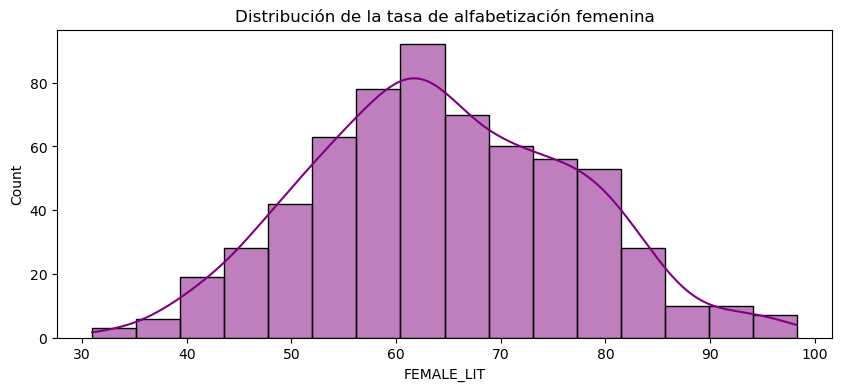

C:\Users\Milag\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


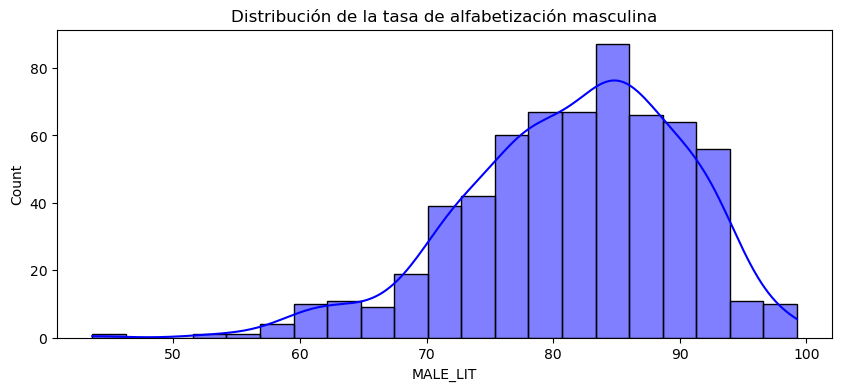

In [27]:
#Histograma
plt.figure(figsize=(10,4))
sns.histplot(df["FEMALE_LIT"], kde=True, color="purple")
plt.title("Distribución de la tasa de alfabetización femenina")
plt.savefig("female_literacy_hist.png")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(df["MALE_LIT"], kde=True, color="blue")
plt.title("Distribución de la tasa de alfabetización masculina")
plt.savefig("male_literacy_hist.png")
plt.show()

In [28]:
#low-dimensional model
X = df[["MALE_LIT"]]
y = df["FEMALE_LIT"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_low = LassoCV(cv=5, alphas=np.logspace(-3,4,100), random_state=42)
lasso_low.fit(X_train_scaled, y_train)

y_pred_low = lasso_low.predict(X_test_scaled)
r2_low = r2_score(y_test, y_pred_low)

In [38]:
print(f'{r2_low:.4f}')

0.7683


In [34]:
#high-dimensional model
predictors = ["MALE_LIT", "TOTPOPULAT", "P_URB_POP", "SEXRATIO", 
              "OVERALL_LI", "AREA_SQKM", "TOT_6_10_15", "TOT_11_13_15", 
              "SCH1", "SCH2", "SCH3"]

X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(df[predictors])

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_poly, y, test_size=0.3, random_state=42)

scaler_p = StandardScaler()
X_train_p_scaled = scaler_p.fit_transform(X_train_p)
X_test_p_scaled = scaler_p.transform(X_test_p)

lasso_high = LassoCV(cv=5, alphas=np.logspace(-3,4,100), random_state=42, max_iter=10000)
lasso_high.fit(X_train_p_scaled, y_train_p)

y_pred_high = lasso_high.predict(X_test_p_scaled)
r2_high = r2_score(y_test_p, y_pred_high)

In [37]:
print(f'{r2_high:.4f}')

0.9988


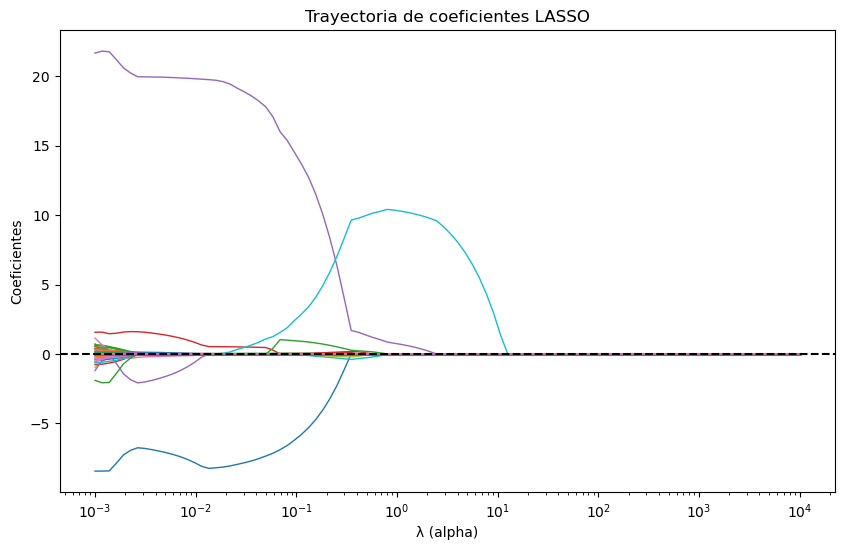

In [39]:
#path of coefficients
alphas = np.logspace(4, -3, 100)  # λ de 10,000 a 0.001
lasso_path = [Lasso(alpha=a, max_iter=10000).fit(X_train_p_scaled, y_train_p) for a in alphas]

coefs = np.array([m.coef_ for m in lasso_path])  # shape: (100, n_features)

plt.figure(figsize=(10,6))
for i in range(coefs.shape[1]):
    plt.plot(alphas, coefs[:, i], lw=1)

plt.xscale("log")
plt.xlabel("λ (alpha)")
plt.ylabel("Coeficientes")
plt.title("Trayectoria de coeficientes LASSO")
plt.axhline(0, color="black", linestyle="--")
plt.savefig("lasso_path.png")
plt.show()


En el gráfico se ve cómo los coeficientes van cambiando cuando varía el valor de λ. Al inicio, con valores de λ muy pequeños, casi todas las variables tienen coeficientes distintos de cero, parecido a una regresión normal. Pero cuando λ empieza a crecer, varios coeficientes se van acercando a cero y algunos desaparecen por completo, lo que significa que el LASSO va “apagando” variables que no son tan importantes. Al final, cuando λ es muy grande, todos los coeficientes terminan en cero y el modelo prácticamente no explica nada.